<a href="https://colab.research.google.com/github/Ainapalma/Ainapalma/blob/main/Oliver_Wyman_Interview_Task_by_Aina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 ‐ Exploratory data analysis



In [185]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [186]:
pip install transliterate

In [187]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

import transliterate
from collections import Counter
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

import os
import io
import glob
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [188]:
os.chdir('/gdrive/MyDrive/datasets/')

In [189]:
!apt-get install p7zip-full
!p7zip -d data.7z

'!apt-get install p7zip-full\n!p7zip -d data.7z'

In [190]:
def first_and_last_dates(data):
  print('Start:', data.sort_values().min())
  print('End:', data.sort_values().max())

In [191]:
def duplicates_and_null_values(df, duplicates, null_all, null_ratio):
  if duplicates:
    print('Number of duplicates:', df.duplicated().sum(), '\n')

  if null_all:
    print('Percentage of missing data: {:.2f}'. format((((df.isnull().sum()).sum()) / np.product(df.shape)) * 100))

  if null_ratio:
    print('Ratio of null values:')
    print((df.isnull().sum() / len(df)).sort_values(ascending=False) * 100)

In [192]:
def unique_values_info(df, col_list):
  for col in col_list:
    print('Feature:', col,
          '\n Total unique values:', df[col].nunique(),
          '\n Top 10:')
    print(df[col].value_counts(dropna=False, ascending=False).head(10), '\n')

In [193]:
def drop_almost_null_columns(df):
  cols = [col for col in df.columns 
          if df[col].isnull().sum() / len(df) > 0.75]
  df.drop(cols, axis=1, inplace=True)

In [194]:
def filling_missing_values(df):
  for col in df.columns:
    df[col] = df.groupby(['id'], sort=False)[col].apply(lambda x: x.ffill().bfill())

## 1.1. Qualitative data

- id: ID компании
- activities: Основной, дополнительный виды деятельности
- regInfo: Сведения о регистрации (Дата присвоения ОГРН; Наименование органа, зарегистрировавшего юрлицо до 1 июля 2002 года)
- regBody: Сведения о постановке на учет в налоговом органе
- statedCapital: Уставный капитал

In [195]:
# loading qualitive data
qual_files = glob.glob('qual/*.json')
qual_files_dict = {v:k for v, k in enumerate(qual_files, 1)}
qual_data = []

len(qual_files_dict)

3918

In [196]:
for k,v in qual_files_dict.items():
      if 1 <= k <= 3918:
        with open(v, 'r', encoding='windows-1251') as d:
            jdata = json.load(d)
            if jdata:
                qual_data.append(jdata)

In [197]:
# head
df_qual_full = pd.json_normalize(qual_data)
df_qual_full.head()

,id,activities.principalActivity.code,activities.principalActivity.text,activities.principalActivity.date,activities.complementaryActivities,activities.okvedVersion,regInfo.ogrnDate,regInfo.regName,regInfo.regNum,regBody.nalogCode,regBody.nalogName,regBody.nalogRegAddress,regBody.date,statedCapital.sum,statedCapital.date
0,3267,10.5,Производство молочной продукции,2005-09-29,"[{'code': '46.33.1', 'text': 'Торговля оптовая...",2,2002-09-13,Администрация муниципального образования 'Поро...,276,6501,Межрайонная инспекция Федеральной налоговой сл...,"693020,Южно-Сахалинск г,Ленина ул,105,А",2015-10-30,1722000.0,2011-05-17
1,3271,46.73,"Торговля оптовая лесоматериалами, строительным...",2007-10-15,"[{'code': '47.52', 'text': 'Торговля розничная...",2,2007-10-15,NaN,NaN,5958,Межрайонная инспекция Федеральной налоговой сл...,"614070,Пермский край,Пермь г,Гагарина б-р,44",2014-02-07,2010000.0,2008-08-06
2,3270,49.41.1,Перевозка грузов специализированными автотранс...,2009-09-17,"[{'code': '09.10.9', 'text': 'Предоставление п...",2,2002-12-09,Администрация муниципального образования город...,95,8617,Инспекция Федеральной налоговой службы по Сург...,"628408, Ханты-Мансийский - Югра АО, Сургут г, ...",2015-05-20,10000.0,2002-12-09
3,3268,46.1,Торговля оптовая за вознаграждение или на дого...,2013-01-30,"[{'code': '46.4', 'text': 'Торговля оптовая не...",2,2013-01-30,NaN,NaN,7746,Межрайонная инспекция Федеральной налоговой сл...,"125373, г.Москва, Походный проезд, домовладени...",2013-01-30,10000.0,2013-01-30
4,3275,68.20.2,Аренда и управление собственным или арендованн...,2011-08-16,"[{'code': '68.32.2', 'text': 'Управление экспл...",2,2002-12-17,Регистрационная палата Администрации Санкт-Пет...,283427,7847,Межрайонная инспекция Федеральной налоговой сл...,"191124, Санкт-Петербург г, Красного Текстильщи...",2005-04-29,46867.0,2008-12-11


In [198]:
# converting columns with dates to datetime
for col in ['regInfo.ogrnDate', 'regBody.date', 'statedCapital.date']:
  df_qual_full[col] = pd.to_datetime(df_qual_full[col], format='%Y-%m-%d')
  print('Name:', col)
  first_and_last_dates(df_qual_full[col])
  print('\n')

Name: regInfo.ogrnDate
Start: 2002-07-05 00:00:00
End: 2019-03-15 00:00:00


Name: regBody.date
Start: 2002-07-16 00:00:00
End: 2021-01-22 00:00:00


Name: statedCapital.date
Start: 2002-07-05 00:00:00
End: 2021-01-29 00:00:00




In [199]:
# copy of relevant data
df_qual = df_qual_full[['id', 
                        'activities.principalActivity.code', 'activities.principalActivity.text', 
                        'regInfo.ogrnDate', 'regBody.nalogCode', 'regBody.date',
                        'statedCapital.sum', 'statedCapital.date']].copy()
df_qual['regInfo.ogrnYear'] = pd.DatetimeIndex(df_qual['regInfo.ogrnDate']).year
df_qual.head()

,id,activities.principalActivity.code,activities.principalActivity.text,regInfo.ogrnDate,regBody.nalogCode,regBody.date,statedCapital.sum,statedCapital.date,regInfo.ogrnYear
0,3267,10.5,Производство молочной продукции,2002-09-13,6501,2015-10-30,1722000.0,2011-05-17,2002
1,3271,46.73,"Торговля оптовая лесоматериалами, строительным...",2007-10-15,5958,2014-02-07,2010000.0,2008-08-06,2007
2,3270,49.41.1,Перевозка грузов специализированными автотранс...,2002-12-09,8617,2015-05-20,10000.0,2002-12-09,2002
3,3268,46.1,Торговля оптовая за вознаграждение или на дого...,2013-01-30,7746,2013-01-30,10000.0,2013-01-30,2013
4,3275,68.20.2,Аренда и управление собственным или арендованн...,2002-12-17,7847,2005-04-29,46867.0,2008-12-11,2002


In [200]:
# main information
df_qual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 3918 non-null   int64         
 1   activities.principalActivity.code  3917 non-null   object        
 2   activities.principalActivity.text  3917 non-null   object        
 3   regInfo.ogrnDate                   3918 non-null   datetime64[ns]
 4   regBody.nalogCode                  3918 non-null   object        
 5   regBody.date                       3918 non-null   datetime64[ns]
 6   statedCapital.sum                  3766 non-null   float64       
 7   statedCapital.date                 3766 non-null   datetime64[ns]
 8   regInfo.ogrnYear                   3918 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(3)
memory usage: 275.6+ KB


In [201]:
duplicates_and_null_values(df_qual, 1, 1, 1)

Number of duplicates: 0 

Percentage of missing data: 0.87
Ratio of null values:
statedCapital.date                   3.879530
statedCapital.sum                    3.879530
activities.principalActivity.text    0.025523
activities.principalActivity.code    0.025523
regInfo.ogrnYear                     0.000000
regBody.date                         0.000000
regBody.nalogCode                    0.000000
regInfo.ogrnDate                     0.000000
id                                   0.000000
dtype: float64


In [202]:
# companies with missing capital value
missed_capital_value = df_qual[df_qual['statedCapital.sum'].isnull()]
missed_capital_value.head(5)

,id,activities.principalActivity.code,activities.principalActivity.text,regInfo.ogrnDate,regBody.nalogCode,regBody.date,statedCapital.sum,statedCapital.date,regInfo.ogrnYear
60,3346,52.10,Деятельность по складированию и хранению,2002-12-12,5476,2010-05-06,NaN,NaT,2002
72,3349,02.20,Лесозаготовки,2002-08-23,1001,2015-03-31,NaN,NaT,2002
82,3353,23.61,Производство изделий из бетона для использован...,2002-09-20,6451,2002-09-20,NaN,NaT,2002
141,3431,45.11.2,Торговля розничная легковыми автомобилями и ле...,2002-12-07,1690,2016-04-30,NaN,NaT,2002
161,3445,47.30,Торговля розничная моторным топливом в специал...,2002-09-02,6027,2015-04-14,NaN,NaT,2002


In [203]:
# mostly registered in 2002-2003
missed_capital_value['regInfo.ogrnYear'].value_counts()

2002    128
2003     23
2013      1
Name: regInfo.ogrnYear, dtype: int64

In [204]:
unique_values_info(df_qual, ['activities.principalActivity.text', 'activities.principalActivity.code', 'regBody.nalogCode'])

Feature: activities.principalActivity.text 
 Total unique values: 712 
 Top 10:
Строительство жилых и нежилых зданий                                                                 285
Торговля оптовая неспециализированная                                                                192
Торговля оптовая лесоматериалами, строительными материалами и санитарно-техническим оборудованием     78
Аренда и управление собственным или арендованным нежилым недвижимым имуществом                        70
Торговля оптовая твердым, жидким и газообразным топливом и подобными продуктами                       64
Аренда и управление собственным или арендованным недвижимым имуществом                                57
Деятельность вспомогательная прочая, связанная с перевозками                                          56
Торговля оптовая прочими строительными материалами и изделиями                                        53
Торговля оптовая фармацевтической продукцией                                    

- There are data on 3 918 firms, of which the majority are in the real estate sector: ~ 40% of construction, about the same number of companies engaged in the wholesale of building materials and rent. Other leading areas - auto industry and pharmaceuticals
- Legal entities were registered in the period from 2002 to 2019
- Approximately a quarter (917) are registered in Moscow and 230 in the Moscow region, in St. Petersburg 310

## 1.2. Financial data

- id: ID компании
- buhForms: Бухгалтерские формы
 - year: Год отчетности
 - organizationType: Размер организации
 - form1: Форма 1 бухгалтерской отчетности
 - form2: Форма 2 бухгалтерской отчетности
   - code: РСБУ-код
   - name: Расшифровка РСБУ-кода
   - startValue: Значение на начало года
   - endValue: Значение на конец года

In [205]:
# loading financial data
fin_files = glob.glob('fin/*.json')
fin_files_dict = {v:k for v, k in enumerate(fin_files, 1)}
fin_data = []

len(fin_files_dict)

3918

In [206]:
for k,v in fin_files_dict.items():
      if 1 <= k <= 3918:
        with open(v, 'r', encoding='windows-1251') as d:
            jdata = json.load(d)
            if jdata:
                fin_data.append(jdata)

In [207]:
df_fin_full = pd.json_normalize(fin_data, ['buhForms'], meta = ['id'])
df_fin_full.head()

,year,organizationType,form1,form2,id
0,2012,Small,"[{'code': 1110, 'name': 'Нематериальные, финан...","[{'code': 2110, 'name': 'Выручка', 'startValue...",3267
1,2013,Large,"[{'code': 1100, 'name': 'Итого', 'startValue':...","[{'code': 2100, 'name': 'Валовая прибыль (убыт...",3267
2,2014,Large,"[{'code': 1100, 'name': 'Итого', 'startValue':...","[{'code': 2100, 'name': 'Валовая прибыль (убыт...",3267
3,2015,Large,"[{'code': 1100, 'name': 'Итого', 'startValue':...","[{'code': 2100, 'name': 'Валовая прибыль (убыт...",3267
4,2016,Large,"[{'code': 1100, 'name': 'Итого', 'startValue':...","[{'code': 2100, 'name': 'Валовая прибыль (убыт...",3267


In [208]:
first_and_last_dates(df_fin_full['year'])

Start: 2012
End: 2019


In [209]:
# copy of organization info
df_org_info = df_fin_full[['id', 'year', 'organizationType']].copy()
df_org_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25016 entries, 0 to 25015
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                25016 non-null  object
 1   year              25016 non-null  int64 
 2   organizationType  25016 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.4+ KB


In [210]:
# pivot table with organization info
df_org_info_by_id_last_year = df_org_info.pivot_table(index = ['id'],
                                                 aggfunc = {'year': ['count', 'max'],
                                                            'organizationType' : 'max'}).reset_index()
df_org_info_by_id_last_year.columns = ['id', 'organizationType', 'num_of_forms', 'last_year']
df_org_info_by_id_last_year.head()

,id,organizationType,num_of_forms,last_year
0,0,Large,3,2014
1,1,Small,7,2019
2,2,Small,5,2016
3,3,Small,8,2019
4,4,Large,8,2019


### 1.2.1. Form 1

In [211]:
df_form_1 = pd.io.json.json_normalize(fin_data, ['buhForms', 'form1'], 
                                      meta=['id', ['buhForms', 'organizationType'], ['buhForms', 'year']],
                                      errors='ignore', record_prefix='form1_')

df_form_1['form1_annualShift'] = df_form_1['form1_endValue'] - df_form_1['form1_startValue']

df_form_1.info()
df_form_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800263 entries, 0 to 800262
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   form1_code                 800263 non-null  int64  
 1   form1_name                 800263 non-null  object 
 2   form1_startValue           796974 non-null  float64
 3   form1_endValue             800248 non-null  float64
 4   id                         800263 non-null  object 
 5   buhForms.organizationType  800263 non-null  object 
 6   buhForms.year              800263 non-null  object 
 7   form1_annualShift          796959 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 48.8+ MB


,form1_code,form1_name,form1_startValue,form1_endValue,id,buhForms.organizationType,buhForms.year,form1_annualShift
0,1110,"Нематериальные, финансовые и другие внеоборотн...",0.0,0.0,3267,Small,2012,0.0
1,1120,"Нематериальные, финансовые и другие внеоборотн...",0.0,0.0,3267,Small,2012,0.0
2,1130,"Нематериальные, финансовые и другие внеоборотн...",0.0,0.0,3267,Small,2012,0.0
3,1140,"Нематериальные, финансовые и другие внеоборотн...",0.0,0.0,3267,Small,2012,0.0
4,1150,Материальные внеоборотные активы,9388000.0,12203000.0,3267,Small,2012,2815000.0


In [212]:
duplicates_and_null_values(df_form_1, 1, 1, 1)

Number of duplicates: 0 

Percentage of missing data: 0.10
Ratio of null values:
form1_annualShift            0.412864
form1_startValue             0.410990
form1_endValue               0.001874
buhForms.year                0.000000
buhForms.organizationType    0.000000
id                           0.000000
form1_name                   0.000000
form1_code                   0.000000
dtype: float64


In [213]:
for col in ['form1_code', 'form1_name']:
    print('Total number of unique values', col, ':', df_form_1[col].nunique(), 
          '\n including: \n', df_form_1[col].unique(), '\n')

Total number of unique values form1_code : 37 
 including: 
 [1110 1120 1130 1140 1150 1160 1170 1180 1190 1210 1220 1230 1240 1250
 1260 1300 1410 1420 1430 1450 1510 1520 1530 1540 1550 1600 1700 1100
 1200 1310 1320 1340 1350 1360 1370 1400 1500] 

Total number of unique values form1_name : 37 
 including: 
 ['Нематериальные, финансовые и другие внеоборотные активы'
 'Материальные внеоборотные активы' 'Запасы'
 'Финансовые и другие оборотные активы'
 'Денежные средства и денежные эквиваленты' 'Капитал и резервы'
 'Долгосрочные заемные средства' 'Другие долгосрочные обязательства'
 'Краткосрочные заемные средства' 'Кредиторская задолженность'
 'Другие краткосрочные обязательства' 'Баланс' 'Итого'
 'Нематериальные активы' 'Результаты исследований и разработок'
 'Нематериальные поисковые активы' 'Материальные поисковые активы'
 'Основные средства' 'Доходные вложения в материальные ценности'
 'Финансовые вложения' 'Отложенные налоговые активы'
 'Прочие внеоборотные активы' 'НДС по приоб

In [214]:
form1_names_sorted = sorted(df_form_1['form1_name'].unique(), key=lambda x: transliterate.translit(x, 'ru'))
print('Columns sorted by cyrillic alphabet:', form1_names_sorted)

Columns sorted by cyrillic alphabet: ['Баланс', 'Дебиторская задолженность', 'Денежные средства и денежные эквиваленты', 'Добавочный капитал (без переоценки)', 'Долгосрочные заемные средства', 'Доходные вложения в материальные ценности', 'Доходы будущих периодов', 'Другие долгосрочные обязательства', 'Другие краткосрочные обязательства', 'Заемные средства', 'Запасы', 'Итого', 'Капитал и резервы', 'Краткосрочные заемные средства', 'Кредиторская задолженность', 'Материальные внеоборотные активы', 'Материальные поисковые активы', 'НДС по приобретенным ценностям', 'Нематериальные активы', 'Нематериальные поисковые активы', 'Нематериальные, финансовые и другие внеоборотные активы', 'Нераспределенная прибыль (непокрытый убыток)', 'Основные средства', 'Отложенные налоговые активы', 'Отложенные налоговые обязательства', 'Оценочные обязательства', 'Переоценка внеоборотных активов', 'Прочие внеоборотные активы', 'Прочие оборотные активы', 'Прочие обязательства', 'Резервный капитал', 'Результаты 

In [215]:
df_form_1_end_values = df_form_1.pivot_table(index=['id', 'buhForms.year'], 
                                        columns=['form1_name'],
                                        values=['form1_endValue']).reset_index()
                                      
df_form_1_end_values.columns = ['id', 'year'] + form1_names_sorted
df_form_1_end_values.head()

,id,year,Баланс,Дебиторская задолженность,Денежные средства и денежные эквиваленты,Добавочный капитал (без переоценки),Долгосрочные заемные средства,Доходные вложения в материальные ценности,Доходы будущих периодов,Другие долгосрочные обязательства,Другие краткосрочные обязательства,Заемные средства,Запасы,Итого,Капитал и резервы,Краткосрочные заемные средства,Кредиторская задолженность,Материальные внеоборотные активы,Материальные поисковые активы,НДС по приобретенным ценностям,Нематериальные активы,Нематериальные поисковые активы,"Нематериальные, финансовые и другие внеоборотные активы",Нераспределенная прибыль (непокрытый убыток),Основные средства,Отложенные налоговые активы,Отложенные налоговые обязательства,Оценочные обязательства,Переоценка внеоборотных активов,Прочие внеоборотные активы,Прочие оборотные активы,Прочие обязательства,Резервный капитал,Результаты исследований и разработок,"Собственные акции, выкупленные у акционеров",Уставный капитал,Финансовые вложения,Финансовые вложения (за исключением денежных эквивалентов),Финансовые и другие оборотные активы
0,0,2012,71451000.0,8247000.0,37940000.0,0.0,NaN,0.0,0.0,NaN,NaN,9625000.0,4225000.0,28580400.0,NaN,NaN,43841000.0,NaN,0.0,0.0,0.0,0.0,NaN,4764000.0,2316000.0,1603000.0,166000.0,215000.0,0.0,0.0,170000.0,0.0,0.0,0.0,0.0,3000000.0,15750000.0,1200000.0,NaN
1,0,2013,93654000.0,0.0,55875000.0,0.0,NaN,0.0,0.0,NaN,NaN,9625000.0,3140000.0,37461600.0,NaN,NaN,65181000.0,NaN,0.0,12208000.0,0.0,0.0,NaN,5818000.0,1679000.0,1252000.0,122000.0,141500.0,0.0,0.0,550000.0,0.0,0.0,0.0,0.0,3000000.0,15750000.0,3200000.0,NaN
2,0,2014,89061000.0,5051000.0,60374000.0,0.0,NaN,0.0,0.0,NaN,NaN,8972500.0,2091000.0,35624400.0,NaN,NaN,62357000.0,NaN,0.0,8000.0,0.0,0.0,NaN,5574000.0,1177000.0,808000.0,77000.0,50000.0,0.0,0.0,602000.0,4000.0,0.0,0.0,0.0,3000000.0,15750000.0,3200000.0,NaN
3,1,2012,4063000.0,NaN,2850000.0,NaN,0.0,NaN,NaN,0.0,333.333333,NaN,0.0,NaN,601000.0,150000.0,3311000.0,321000.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223000.0
4,1,2013,8109000.0,1576000.0,1921000.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,1621000.0,3243800.0,NaN,NaN,6525000.0,NaN,0.0,0.0,0.0,0.0,NaN,1568000.0,2622000.0,0.0,0.0,0.0,0.0,0.0,369000.0,0.0,0.0,0.0,0.0,16000.0,0.0,0.0,NaN


In [216]:
duplicates_and_null_values(df_form_1_end_values, 1, 1, 1)

Number of duplicates: 0 

Percentage of missing data: 33.16
Ratio of null values:
Другие краткосрочные обязательства                            82.167413
Другие долгосрочные обязательства                             81.995523
Нематериальные, финансовые и другие внеоборотные активы       81.699712
Долгосрочные заемные средства                                 81.283978
Краткосрочные заемные средства                                80.500480
Материальные внеоборотные активы                              80.372562
Финансовые и другие оборотные активы                          79.645027
Капитал и резервы                                             79.621043
Материальные поисковые активы                                 29.477135
Нематериальные поисковые активы                               29.417173
Собственные акции, выкупленные у акционеров                   29.409178
Результаты исследований и разработок                          29.189319
Доходы будущих периодов                               

In [217]:
drop_almost_null_columns(df_form_1_end_values)
duplicates_and_null_values(df_form_1_end_values, 0, 1, 0)

Percentage of missing data: 20.84


In [218]:
filling_missing_values(df_form_1_end_values)
duplicates_and_null_values(df_form_1_end_values, 0, 1, 0)

Percentage of missing data: 0.60


In [219]:
df_form_1_end_values.head()

,id,year,Баланс,Дебиторская задолженность,Денежные средства и денежные эквиваленты,Добавочный капитал (без переоценки),Доходные вложения в материальные ценности,Доходы будущих периодов,Заемные средства,Запасы,Итого,Кредиторская задолженность,Материальные поисковые активы,НДС по приобретенным ценностям,Нематериальные активы,Нематериальные поисковые активы,Нераспределенная прибыль (непокрытый убыток),Основные средства,Отложенные налоговые активы,Отложенные налоговые обязательства,Оценочные обязательства,Переоценка внеоборотных активов,Прочие внеоборотные активы,Прочие оборотные активы,Прочие обязательства,Резервный капитал,Результаты исследований и разработок,"Собственные акции, выкупленные у акционеров",Уставный капитал,Финансовые вложения,Финансовые вложения (за исключением денежных эквивалентов)
0,0,2012,71451000.0,8247000.0,37940000.0,0.0,0.0,0.0,9625000.0,4225000.0,28580400.0,43841000.0,0.0,0.0,0.0,0.0,4764000.0,2316000.0,1603000.0,166000.0,215000.0,0.0,0.0,170000.0,0.0,0.0,0.0,0.0,3000000.0,15750000.0,1200000.0
1,0,2013,93654000.0,0.0,55875000.0,0.0,0.0,0.0,9625000.0,3140000.0,37461600.0,65181000.0,0.0,12208000.0,0.0,0.0,5818000.0,1679000.0,1252000.0,122000.0,141500.0,0.0,0.0,550000.0,0.0,0.0,0.0,0.0,3000000.0,15750000.0,3200000.0
2,0,2014,89061000.0,5051000.0,60374000.0,0.0,0.0,0.0,8972500.0,2091000.0,35624400.0,62357000.0,0.0,8000.0,0.0,0.0,5574000.0,1177000.0,808000.0,77000.0,50000.0,0.0,0.0,602000.0,4000.0,0.0,0.0,0.0,3000000.0,15750000.0,3200000.0
3,1,2012,4063000.0,1576000.0,2850000.0,0.0,0.0,0.0,0.0,0.0,3243800.0,3311000.0,0.0,0.0,0.0,0.0,1568000.0,2622000.0,0.0,0.0,0.0,0.0,0.0,369000.0,0.0,0.0,0.0,0.0,16000.0,0.0,0.0
4,1,2013,8109000.0,1576000.0,1921000.0,0.0,0.0,0.0,0.0,1621000.0,3243800.0,6525000.0,0.0,0.0,0.0,0.0,1568000.0,2622000.0,0.0,0.0,0.0,0.0,0.0,369000.0,0.0,0.0,0.0,0.0,16000.0,0.0,0.0


In [220]:
df_form_1_end_values = df_form_1_end_values.fillna(0).astype('int')

In [221]:
df_form_1_last_end_values_keys = df_form_1_end_values.groupby(['id']).agg({'year': 'max'}).reset_index()
df_form_1_last_end_values = df_form_1_end_values.merge(df_form_1_last_end_values_keys, on = ['id', 'year'])
df_form_1_last_end_values

,id,year,Баланс,Дебиторская задолженность,Денежные средства и денежные эквиваленты,Добавочный капитал (без переоценки),Доходные вложения в материальные ценности,Доходы будущих периодов,Заемные средства,Запасы,Итого,Кредиторская задолженность,Материальные поисковые активы,НДС по приобретенным ценностям,Нематериальные активы,Нематериальные поисковые активы,Нераспределенная прибыль (непокрытый убыток),Основные средства,Отложенные налоговые активы,Отложенные налоговые обязательства,Оценочные обязательства,Переоценка внеоборотных активов,Прочие внеоборотные активы,Прочие оборотные активы,Прочие обязательства,Резервный капитал,Результаты исследований и разработок,"Собственные акции, выкупленные у акционеров",Уставный капитал,Финансовые вложения,Финансовые вложения (за исключением денежных эквивалентов)
0,0,2014,89061000,5051000,60374000,0,0,0,8972500,2091000,35624400,62357000,0,8000,0,0,5574000,1177000,808000,77000,50000,0,0,602000,4000,0,0,0,3000000,15750000,3200000
1,1,2019,19410000,6916000,1489000,0,0,0,0,9814000,3673600,8976000,0,0,0,0,0,59000,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2016,59000,58000,1000,0,0,0,20442500,0,23600,27919000,0,0,0,0,-861422000,0,0,0,396333500,0,0,0,0,0,0,0,10000,0,0
3,3,2019,989798000,416919000,34831000,0,0,0,67160500,301147000,395919200,437090000,0,720000,384000,0,388975000,40912000,514000,2499000,8456500,0,1308000,5173000,0,0,0,0,10000000,571000,187319000
4,4,2019,310724000,58099000,2568000,0,0,0,0,15822000,124289600,21329000,0,2017000,0,0,86672000,198783000,415000,3222000,2076000,0,0,33020000,197415000,0,0,0,10000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3913,4389,2019,7865000,6862000,726000,0,0,0,0,463000,4585800,5509000,0,0,0,0,0,595000,0,0,0,0,0,0,0,0,0,0,0,59000,0
3914,4390,2019,3953382000,550171000,18412000,0,0,0,753633500,848173000,1581352800,1593598000,0,223267000,117097000,0,388463000,2072824000,44034000,157516000,62998000,42815000,0,79394000,0,0,0,0,200725000,0,10000
3915,4391,2019,257446000,116866000,1345000,0,0,0,9606000,131201000,128723000,232977000,0,1382000,0,0,14853000,6652000,0,0,0,0,0,0,0,0,0,0,10000,0,0
3916,4392,2019,133519000,39895000,37000,0,0,0,0,63409000,53407200,54750000,0,0,0,0,64474000,17539000,10638000,2986000,9180000,0,0,0,0,2029000,0,0,100000,0,2000000


In [222]:
df_form_1_last_end_values.describe()

,id,year,Баланс,Дебиторская задолженность,Денежные средства и денежные эквиваленты,Добавочный капитал (без переоценки),Доходные вложения в материальные ценности,Доходы будущих периодов,Заемные средства,Запасы,Итого,Кредиторская задолженность,Материальные поисковые активы,НДС по приобретенным ценностям,Нематериальные активы,Нематериальные поисковые активы,Нераспределенная прибыль (непокрытый убыток),Основные средства,Отложенные налоговые активы,Отложенные налоговые обязательства,Оценочные обязательства,Переоценка внеоборотных активов,Прочие внеоборотные активы,Прочие оборотные активы,Прочие обязательства,Резервный капитал,Результаты исследований и разработок,"Собственные акции, выкупленные у акционеров",Уставный капитал,Финансовые вложения,Финансовые вложения (за исключением денежных эквивалентов)
count,3918.000000,3918.000000,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03
mean,2191.348903,2018.418836,8.279285e+08,1.695782e+08,4.971126e+07,4.715201e+07,1.217464e+07,4.445679e+06,1.437349e+08,9.897833e+07,3.344976e+08,2.325540e+08,2.748946e+05,5.129640e+06,3.327220e+06,1.102262e+06,1.199932e+08,1.929365e+08,1.029891e+07,2.650140e+07,5.614762e+06,4.702794e+06,4.837784e+07,7.857195e+06,1.657396e+07,6.515666e+05,1.331413e+06,1.684472e+05,8.879913e+07,2.020508e+08,2.410594e+07
std,1272.222772,1.294683,1.324488e+10,9.457159e+08,1.338295e+09,1.107164e+09,3.558590e+08,1.517462e+08,3.034831e+09,6.164927e+08,5.298073e+09,2.973747e+09,1.110204e+07,7.437029e+07,5.704506e+07,3.685370e+07,4.805849e+09,4.003894e+09,1.938969e+08,1.238018e+09,7.597633e+07,8.050486e+07,1.715718e+09,1.356103e+08,2.874051e+08,1.270343e+07,4.529032e+07,1.095913e+07,3.187420e+09,8.281136e+09,1.880935e+08
min,0.000000,2013.000000,0.000000e+00,-1.453000e+06,-6.700000e+04,-7.747900e+07,0.000000e+00,0.000000e+00,-1.296300e+07,0.000000e+00,-1.443820e+07,-5.424000e+06,0.000000e+00,-1.981000e+06,0.000000e+00,0.000000e+00,-1.271506e+11,0.000000e+00,-2.112000e+06,-1.153700e+07,-2.480000e+05,0.000000e+00,0.000000e+00,-7.000000e+05,-3.891000e+06,0.000000e+00,0.000000e+00,-2.950000e+08,-2.721000e+06,0.000000e+00,0.000000e+00
25%,1091.250000,2019.000000,2.509475e+07,5.992250e+06,4.025000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.725000e+05,1.026030e+07,6.789250e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+04,0.000000e+00,0.000000e+00
50%,2183.500000,2019.000000,7.239950e+07,2.469200e+07,6.885000e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.560500e+06,1.007450e+07,3.087740e+07,2.865150e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.269000e+06,1.194000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+04,0.000000e+00,0.000000e+00
75%,3292.750000,2019.000000,2.358230e+08,7.959250e+07,4.916500e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.951288e+07,4.879200e+07,9.751290e+07,9.989050e+07,0.000000e+00,2.040000e+05,0.000000e+00,0.000000e+00,3.452800e+07,1.702675e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.655000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e+05,0.000000e+00,4.560000e+05
max,4393.000000,2019.000000,7.407061e+11,2.820188e+10,8.004590e+10,5.434728e+10,1.957654e+10,8.893004e+09,1.661003e+11,2.494825e+10,2.962825e+11,1.772986e+11,5.931300e+08,3.970234e+09,2.359384e+09,2.064913e+09,2.585418e+11,1.985541e+11,9.613554e+09,7.660621e+10,2.892573e+09,3.658391e+09,9.433300e+10,7.518293e+09,1.022526e+10,6.947390e+08,2.629

### 1.2.2. Form 2

In [223]:
# form 2
df_form_2 = pd.io.json.json_normalize(fin_data, ['buhForms', 'form2'], 
                                      meta=['id', ['buhForms', 'organizationType'], ['buhForms', 'year']],
                                      errors='ignore', record_prefix='form2_')

df_form_2['form2_annualValue'] = df_form_2['form2_endValue'] - df_form_2['form2_startValue']

df_form_2.info()
df_form_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437014 entries, 0 to 437013
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   form2_code                 437014 non-null  int64  
 1   form2_name                 437014 non-null  object 
 2   form2_startValue           434678 non-null  float64
 3   form2_endValue             437005 non-null  float64
 4   id                         437014 non-null  object 
 5   buhForms.organizationType  437014 non-null  object 
 6   buhForms.year              437014 non-null  object 
 7   form2_annualValue          434669 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 26.7+ MB


,form2_code,form2_name,form2_startValue,form2_endValue,id,buhForms.organizationType,buhForms.year,form2_annualValue
0,2110,Выручка,143632000.0,162430000.0,3267,Small,2012,18798000.0
1,2120,Расходы по обычной деятельности,131942000.0,152806000.0,3267,Small,2012,20864000.0
2,2330,Проценты к уплате,763000.0,230000.0,3267,Small,2012,-533000.0
3,2340,Прочие доходы,644000.0,684000.0,3267,Small,2012,40000.0
4,2350,Прочие расходы,1693000.0,1816000.0,3267,Small,2012,123000.0


In [224]:
duplicates_and_null_values(df_form_2, 1, 1, 1)

Number of duplicates: 0 

Percentage of missing data: 0.13
Ratio of null values:
form2_annualValue            0.536596
form2_startValue             0.534537
form2_endValue               0.002059
buhForms.year                0.000000
buhForms.organizationType    0.000000
id                           0.000000
form2_name                   0.000000
form2_code                   0.000000
dtype: float64


In [225]:
for col in ['form2_code', 'form2_name']:
    print('Total number of unique values', col, ':', df_form_2[col].nunique(), 
          '\n including: \n', df_form_2[col].unique(), '\n')

Total number of unique values form2_code : 26 
 including: 
 [2110 2120 2330 2340 2350 2400 2410 2100 2200 2210 2220 2300 2310 2320
 2421 2430 2450 2460 2500 2510 2520 2411 2412 2530 2900 2910] 

Total number of unique values form2_name : 28 
 including: 
 ['Выручка' 'Расходы по обычной деятельности' 'Проценты к уплате'
 'Прочие доходы' 'Прочие расходы' 'Чистая прибыль (убыток)'
 'Налоги на прибыль (доходы)' 'Валовая прибыль (убыток)'
 'Себестоимость продаж' 'Прибыль (убыток) от продаж'
 'Коммерческие расходы' 'Управленческие расходы'
 'Прибыль (убыток) до налогообложения'
 'Доходы от участия в других организациях' 'Проценты к получению'
 'Текущий налог на прибыль' 'Постоянные налоговые обязательства (активы)'
 'Изменение отложенных налоговых обязательств'
 'Изменение отложенных налоговых активов' 'Прочее'
 'Совокупный финансовый результат периода'
 'Результат от переоценки внеоборотных активов, не включаемый в чистую прибыль (убыток)'
 'Результат от прочих операций, не включаемый в чи

In [226]:
form2_name_sorted = sorted(df_form_2['form2_name'].unique(), key=lambda x: transliterate.translit(x, 'ru'))
print('Columns sorted by cyrillic alphabet:', form2_name_sorted)

Columns sorted by cyrillic alphabet: ['Базовая прибыль (убыток) на акцию', 'Валовая прибыль (убыток)', 'Выручка', 'Доходы от участия в других организациях', 'Изменение отложенных налоговых активов', 'Изменение отложенных налоговых обязательств', 'Коммерческие расходы', 'Налог на прибыль', 'Налог на прибыль от операций, результат которых не включается в чистую прибыль (убыток)', 'Налоги на прибыль (доходы)', 'Отложенный налог на прибыль', 'Постоянные налоговые обязательства (активы)', 'Прибыль (убыток) до налогообложения', 'Прибыль (убыток) от продаж', 'Проценты к получению', 'Проценты к уплате', 'Прочее', 'Прочие доходы', 'Прочие расходы', 'Разводненная прибыль (убыток) на акцию', 'Расходы по обычной деятельности', 'Результат от переоценки внеоборотных активов, не включаемый в чистую прибыль (убыток)', 'Результат от прочих операций, не включаемый в чистую прибыль (убыток) периода', 'Себестоимость продаж', 'Совокупный финансовый результат периода', 'Текущий налог на прибыль', 'Управленч

In [227]:
df_form_2_end_values = df_form_2.pivot_table(index=['id', 'buhForms.year'], 
                                        columns=['form2_name'],
                                        values=['form2_endValue']).reset_index()
                                      
df_form_2_end_values.columns = ['id', 'year'] + form2_name_sorted
df_form_2_end_values.head()

,id,year,Базовая прибыль (убыток) на акцию,Валовая прибыль (убыток),Выручка,Доходы от участия в других организациях,Изменение отложенных налоговых активов,Изменение отложенных налоговых обязательств,Коммерческие расходы,Налог на прибыль,"Налог на прибыль от операций, результат которых не включается в чистую прибыль (убыток)",Налоги на прибыль (доходы),Отложенный налог на прибыль,Постоянные налоговые обязательства (активы),Прибыль (убыток) до налогообложения,Прибыль (убыток) от продаж,Проценты к получению,Проценты к уплате,Прочее,Прочие доходы,Прочие расходы,Разводненная прибыль (убыток) на акцию,Расходы по обычной деятельности,"Результат от переоценки внеоборотных активов, не включаемый в чистую прибыль (убыток)","Результат от прочих операций, не включаемый в чистую прибыль (убыток) периода",Себестоимость продаж,Совокупный финансовый результат периода,Текущий налог на прибыль,Управленческие расходы,Чистая прибыль (убыток)
0,0,2012,NaN,96514000.0,124447000.0,1547000.0,502000.0,-45000.0,0.0,NaN,NaN,NaN,NaN,-101000.0,4483000.0,11344000.0,19000.0,3080000.0,5000.0,157000.0,5504000.0,NaN,NaN,0.0,0.0,27933000.0,3683000.0,1342000.0,85170000.0,3683000.0
1,0,2013,NaN,98358000.0,129589000.0,0.0,-351000.0,-44000.0,0.0,NaN,NaN,NaN,NaN,0.0,2181000.0,12614000.0,149000.0,3080000.0,3000.0,27000.0,7526000.0,NaN,NaN,0.0,0.0,31231000.0,1054000.0,817000.0,85744000.0,1054000.0
2,0,2014,NaN,88247000.0,117597000.0,0.0,-444000.0,-45000.0,0.0,NaN,NaN,NaN,NaN,-760000.0,688000.0,9051000.0,0.0,1749000.0,35000.0,88000.0,6702000.0,NaN,NaN,0.0,0.0,29350000.0,-244000.0,498000.0,79196000.0,-244000.0
3,1,2012,NaN,NaN,19388000.0,NaN,NaN,NaN,NaN,NaN,NaN,159000.0,NaN,NaN,NaN,NaN,NaN,7000.0,NaN,5000.0,77000.0,NaN,18529000.0,NaN,NaN,NaN,NaN,NaN,NaN,621000.0
4,1,2013,NaN,1280000.0,28221000.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1107000.0,1280000.0,0.0,0.0,0.0,0.0,173000.0,NaN,NaN,0.0,0.0,26941000.0,1001000.0,106000.0,0.0,1001000.0


In [228]:
duplicates_and_null_values(df_form_2_end_values, 1, 1, 1)

Number of duplicates: 0 

Percentage of missing data: 34.95
Ratio of null values:
Налог на прибыль от операций, результат которых не включается в чистую прибыль (убыток)    99.955915
Разводненная прибыль (убыток) на акцию                                                     99.919846
Базовая прибыль (убыток) на акцию                                                          99.731484
Отложенный налог на прибыль                                                                98.525168
Налог на прибыль                                                                           96.369029
Налоги на прибыль (доходы)                                                                 80.001603
Расходы по обычной деятельности                                                            79.729080
Результат от прочих операций, не включаемый в чистую прибыль (убыток) периода              29.188041
Результат от переоценки внеоборотных активов, не включаемый в чистую прибыль (убыток)      29.131933
Доходы от

In [229]:
drop_almost_null_columns(df_form_2_end_values)
duplicates_and_null_values(df_form_2_end_values, 0, 1, 0)

Percentage of missing data: 17.15


In [230]:
filling_missing_values(df_form_2_end_values)
duplicates_and_null_values(df_form_2_end_values, 0, 1, 0)

Percentage of missing data: 0.52


In [231]:
df_form_2_end_values.head()

,id,year,Валовая прибыль (убыток),Выручка,Доходы от участия в других организациях,Изменение отложенных налоговых активов,Изменение отложенных налоговых обязательств,Коммерческие расходы,Постоянные налоговые обязательства (активы),Прибыль (убыток) до налогообложения,Прибыль (убыток) от продаж,Проценты к получению,Проценты к уплате,Прочее,Прочие доходы,Прочие расходы,"Результат от переоценки внеоборотных активов, не включаемый в чистую прибыль (убыток)","Результат от прочих операций, не включаемый в чистую прибыль (убыток) периода",Себестоимость продаж,Совокупный финансовый результат периода,Текущий налог на прибыль,Управленческие расходы,Чистая прибыль (убыток)
0,0,2012,96514000.0,124447000.0,1547000.0,502000.0,-45000.0,0.0,-101000.0,4483000.0,11344000.0,19000.0,3080000.0,5000.0,157000.0,5504000.0,0.0,0.0,27933000.0,3683000.0,1342000.0,85170000.0,3683000.0
1,0,2013,98358000.0,129589000.0,0.0,-351000.0,-44000.0,0.0,0.0,2181000.0,12614000.0,149000.0,3080000.0,3000.0,27000.0,7526000.0,0.0,0.0,31231000.0,1054000.0,817000.0,85744000.0,1054000.0
2,0,2014,88247000.0,117597000.0,0.0,-444000.0,-45000.0,0.0,-760000.0,688000.0,9051000.0,0.0,1749000.0,35000.0,88000.0,6702000.0,0.0,0.0,29350000.0,-244000.0,498000.0,79196000.0,-244000.0
3,1,2012,1280000.0,19388000.0,0.0,0.0,0.0,0.0,0.0,1107000.0,1280000.0,0.0,7000.0,0.0,5000.0,77000.0,0.0,0.0,26941000.0,1001000.0,106000.0,0.0,621000.0
4,1,2013,1280000.0,28221000.0,0.0,0.0,0.0,0.0,0.0,1107000.0,1280000.0,0.0,0.0,0.0,0.0,173000.0,0.0,0.0,26941000.0,1001000.0,106000.0,0.0,1001000.0


In [232]:
df_form_2_end_values = df_form_2_end_values.fillna(0).astype('int')

In [233]:
df_form_2_last_end_values_keys = df_form_2_end_values.groupby(['id']).agg({'year': 'max'}).reset_index()
df_form_2_last_end_values = df_form_2_end_values.merge(df_form_2_last_end_values_keys, on = ['id', 'year'])
df_form_2_last_end_values

,id,year,Валовая прибыль (убыток),Выручка,Доходы от участия в других организациях,Изменение отложенных налоговых активов,Изменение отложенных налоговых обязательств,Коммерческие расходы,Постоянные налоговые обязательства (активы),Прибыль (убыток) до налогообложения,Прибыль (убыток) от продаж,Проценты к получению,Проценты к уплате,Прочее,Прочие доходы,Прочие расходы,"Результат от переоценки внеоборотных активов, не включаемый в чистую прибыль (убыток)","Результат от прочих операций, не включаемый в чистую прибыль (убыток) периода",Себестоимость продаж,Совокупный финансовый результат периода,Текущий налог на прибыль,Управленческие расходы,Чистая прибыль (убыток)
0,0,2014,88247000,117597000,0,-444000,-45000,0,-760000,688000,9051000,0,1749000,35000,88000,6702000,0,0,29350000,-244000,498000,79196000,-244000
1,1,2019,1268000,31674000,0,0,0,0,0,-47000,1268000,0,7000,0,3578000,3707000,0,0,66519000,0,495000,0,263000
2,2,2016,0,0,0,0,0,749000,0,-6665000,-749000,1856000,986000,0,4000,6790000,0,0,0,-6670000,5000,0,-6670000
3,3,2019,395363000,2538937000,0,-5000,-437000,134741000,1503000,126488000,148021000,520000,17555000,-203000,160192000,164690000,0,0,2143574000,102490000,23353000,112601000,102490000
4,4,2019,12089000,344088000,0,214000,-1511000,0,234000,23858000,10514000,353000,29000,0,35890000,22870000,0,0,331999000,19320000,3241000,1575000,19320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3913,4389,2019,180000,40617000,0,0,0,0,0,11000,180000,0,0,0,374000,1133000,0,0,49733000,0,20000,0,2266000
3914,4390,2019,473575000,4427360000,0,38953000,-419000,293044000,-11523000,-250289000,-51988000,686000,134357000,-1647000,3410039000,3474669000,0,0,3953785000,-213402000,0,232519000,-213402000
3915,4391,2019,5985000,107198000,0,0,0,7149000,0,-2479000,-1164000,0,1485000,0,1103000,933000,0,0,101213000,-2479000,478000,0,-2479000
3916,4392,2019,24555000,253724000,0,-2644000,-117000,1376000,-326000,12177000,-28403000,0,0,-2929000,95362000,54782000,0,0,229169000,6487000,0,51582000,6487000


In [234]:
df_form_2_last_end_values.describe()

,id,year,Валовая прибыль (убыток),Выручка,Доходы от участия в других организациях,Изменение отложенных налоговых активов,Изменение отложенных налоговых обязательств,Коммерческие расходы,Постоянные налоговые обязательства (активы),Прибыль (убыток) до налогообложения,Прибыль (убыток) от продаж,Проценты к получению,Проценты к уплате,Прочее,Прочие доходы,Прочие расходы,"Результат от переоценки внеоборотных активов, не включаемый в чистую прибыль (убыток)","Результат от прочих операций, не включаемый в чистую прибыль (убыток) периода",Себестоимость продаж,Совокупный финансовый результат периода,Текущий налог на прибыль,Управленческие расходы,Чистая прибыль (убыток)
count,3918.000000,3918.000000,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03,3.918000e+03
mean,2191.348903,2018.398673,1.374464e+08,6.243030e+08,3.998843e+06,1.159590e+06,-3.495626e+06,2.327556e+07,2.541130e+06,6.043379e+07,8.002346e+07,4.526785e+06,1.327584e+07,-5.392956e+05,8.094590e+07,8.765324e+07,6.492213e+05,-5.359775e+04,3.826925e+08,4.558849e+07,-2.786780e+06,1.811641e+07,4.553965e+07
std,1272.222772,1.297793,2.104939e+09,4.172482e+09,1.610019e+08,1.320708e+08,1.542250e+08,2.488682e+08,1.417338e+08,2.039753e+09,1.909569e+09,5.765727e+07,3.182687e+08,1.511672e+07,2.175873e+09,2.189363e+09,2.441839e+07,1.574916e+06,2.689207e+09,1.700356e+09,3.124280e+08,1.780828e+08,1.699739e+09
min,0.000000,2013.000000,-3.871840e+08,0.000000e+00,0.000000e+00,-3.924264e+09,-9.163369e+09,-7.184757e+09,-1.224371e+09,-4.317534e+10,-2.711271e+09,0.000000e+00,-2.453807e+09,-8.974470e+08,-7.890000e+06,-3.320212e+09,-1.915060e+08,-5.909000e+07,-6.339559e+10,-4.322729e+10,-1.877439e+10,-2.150178e+09,-4.322729e+10
25%,1091.250000,2019.000000,2.002500e+05,1.712525e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.130000e+05,0.000000e+00,0.000000e+00,6.035500e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2183.500000,2019.000000,8.928000e+06,9.071700e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.153500e+06,1.735000e+06,0.000000e+00,0.000000e+00,0.000000e+00,9.545000e+05,1.765000e+06,0.000000e+00,0.000000e+00,6.728400e+07,1.425000e+05,8.200000e+04,0.000000e+00,7.035000e+05
75%,3292.750000,2019.000000,4.806200e+07,3.030970e+08,0.000000e+00,0.000000e+00,0.000000e+00,6.792500e+06,0.000000e+00,9.099750e+06,1.266525e+07,4.300000e+04,8.435000e+05,0.000000e+00,9.797250e+06,1.184400e+07,0.000000e+00,0.000000e+00,2.309438e+08,5.041750e+06,9.470000e+05,5.661750e+06,7.088000e+06
max,4393.000000,2019.000000,1.141830e+11,1.636536e+11,9.879988e+09,7.207014e+09,5.973800e+08,6.585791e+09,8.636166e+09,1.074119e+11,1.028611e+11,1.952770e+09,1.866230e+10,1.051820e+08,1.342947e+11,1.229144e+11,1.309751e+09,3.072500e+07,6.988172e+10,8.668934e+10,2.916781e+09,9.670982e+09,8.669326e+10


Financial data includes general information about the organizations and 2 forms of balance-sheet, which contained a large amount of NaN values. So features with more than 75% of the missing information were dropped and the rest were filled with last year's values since predictions will be made for a year ahead.

## 1.3. Flags data

- id: ID компании
- default_date: Дата дефолта (решение суда о признании компании банкротом)

In [235]:
# loading flags data
df_flags = pd.read_csv('flags.csv', sep = ';', parse_dates=['default_date'])
df_flags.info()
df_flags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            223 non-null    int64         
 1   default_date  223 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.6 KB


,id,default_date
0,2,2017-07-26
1,29,2015-07-29
2,70,2016-12-29
3,75,2016-01-07
4,81,2019-09-30


In [236]:
# assigning status and extracting year
df_flags['default_status'] = 1
df_flags['default_year'] = pd.DatetimeIndex(df_flags['default_date']).year
df_flags['year'] = df_flags['default_year'] - 1
df_flags.head()

,id,default_date,default_status,default_year,year
0,2,2017-07-26,1,2017,2016
1,29,2015-07-29,1,2015,2014
2,70,2016-12-29,1,2016,2015
3,75,2016-01-07,1,2016,2015
4,81,2019-09-30,1,2019,2018


In [237]:
# default by year
df_default_by_year = df_flags.groupby('default_year').agg({'default_status': 'count'}).reset_index()
df_default_by_year

,default_year,default_status
0,2014,1
1,2015,9
2,2016,17
3,2017,37
4,2018,57
5,2019,40
6,2020,58
7,2021,4


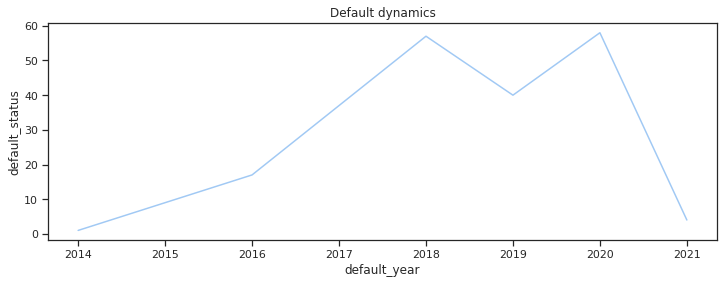

In [238]:
plt.figure(figsize=(12, 4))
sns.lineplot(x=df_default_by_year['default_year'], y=df_default_by_year['default_status'])
plt.title('Default dynamics')
plt.show()

### 1.3.1. Dependencies with qualitative features

In [239]:
# merging with qualitive data
df_default_org_info = pd.merge(df_flags, df_qual[['id', 'regBody.nalogCode', 'statedCapital.sum',
                                      'activities.principalActivity.text']], on=['id'], how='left')
df_default_org_info.rename(columns = {'activities.principalActivity.text': 'activity'}, inplace=True)
df_default_org_info.info()
df_default_org_info.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 0 to 222
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 223 non-null    int64         
 1   default_date       223 non-null    datetime64[ns]
 2   default_status     223 non-null    int64         
 3   default_year       223 non-null    int64         
 4   year               223 non-null    int64         
 5   regBody.nalogCode  223 non-null    object        
 6   statedCapital.sum  214 non-null    float64       
 7   activity           223 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 15.7+ KB


,id,default_date,default_status,default_year,year,regBody.nalogCode,statedCapital.sum,activity
0,2,2017-07-26,1,2017,2016,1215,10000.0,Торговля розничная лекарственными средствами в...
1,29,2015-07-29,1,2015,2014,4205,20000.0,"Оптовая торговля рыбой, морепродуктами и рыбны..."
2,70,2016-12-29,1,2016,2015,6196,10000.0,"Торговля оптовая пищевыми продуктами, напиткам..."
3,75,2016-01-07,1,2016,2015,3328,11000.0,Производство прочих деревянных изделий
4,81,2019-09-30,1,2019,2018,7746,10000.0,"Торговля розничная, осуществляемая непосредств..."


In [240]:
# the most affected sectors
df_by_sector = df_default_org_info.groupby('activity').agg({'default_status': 'count'}).reset_index()
df_by_sector = df_by_sector.sort_values(by='default_status', ascending=False).head()
sectors = df_by_sector['activity']
sectors

80                  Строительство жилых и нежилых зданий
97                 Торговля оптовая неспециализированная
102           Торговля оптовая прочими бытовыми товарами
99     Торговля оптовая пищевыми продуктами, напиткам...
79     Строительство автомобильных дорог и автомагист...
Name: activity, dtype: object

In [241]:
df_default_by_sector = df_default_org_info.query('activity in @sectors')
df_default_by_sector = df_default_by_sector.groupby(['activity', 'default_year']).agg({'default_status': 'count'}).reset_index()


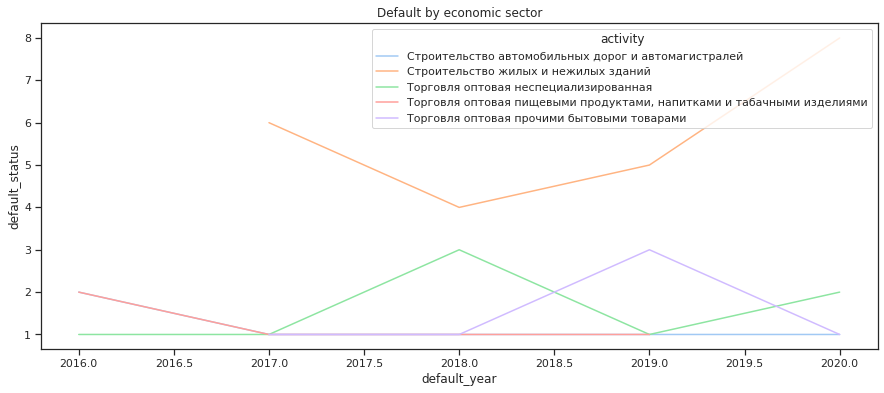

In [242]:
plt.figure(figsize=(15, 6))
sns.lineplot(x = 'default_year', y = 'default_status', hue='activity', data = df_default_by_sector)
plt.title('Default by economic sector')
plt.show()

In [243]:
df_by_type = pd.merge(df_flags, df_org_info_by_id_last_year, on='id', how='left')
df_by_type.info()
df_by_type.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 0 to 222
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                223 non-null    int64         
 1   default_date      223 non-null    datetime64[ns]
 2   default_status    223 non-null    int64         
 3   default_year      223 non-null    int64         
 4   year              223 non-null    int64         
 5   organizationType  223 non-null    object        
 6   num_of_forms      223 non-null    int64         
 7   last_year         223 non-null    int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 15.7+ KB


,id,default_date,default_status,default_year,year,organizationType,num_of_forms,last_year
0,2,2017-07-26,1,2017,2016,Small,5,2016
1,29,2015-07-29,1,2015,2014,Small,3,2014
2,70,2016-12-29,1,2016,2015,Small,4,2015
3,75,2016-01-07,1,2016,2015,Small,2,2013
4,81,2019-09-30,1,2019,2018,Large,1,2016


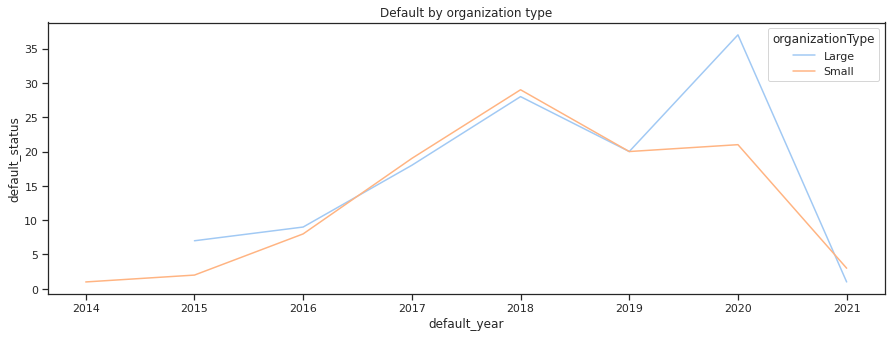

In [244]:
df_default_by_type = df_by_type.groupby(['organizationType', 'default_year']).agg({'default_status': 'count'}).reset_index()

plt.figure(figsize=(15, 5))
sns.lineplot(x = 'default_year', y = 'default_status', hue='organizationType', data = df_default_by_type)
plt.title('Default by organization type')
plt.show()

### 1.3.2. Dependencies with financial features

In [245]:
df_full_forms = pd.merge(df_form_1_last_end_values, df_form_2_last_end_values, on=['id'])
df_full_forms

,id,year_x,Баланс,Дебиторская задолженность,Денежные средства и денежные эквиваленты,Добавочный капитал (без переоценки),Доходные вложения в материальные ценности,Доходы будущих периодов,Заемные средства,Запасы,Итого,Кредиторская задолженность,Материальные поисковые активы,НДС по приобретенным ценностям,Нематериальные активы,Нематериальные поисковые активы,Нераспределенная прибыль (непокрытый убыток),Основные средства,Отложенные налоговые активы,Отложенные налоговые обязательства,Оценочные обязательства,Переоценка внеоборотных активов,Прочие внеоборотные активы,Прочие оборотные активы,Прочие обязательства,Резервный капитал,Результаты исследований и разработок,"Собственные акции, выкупленные у акционеров",Уставный капитал,Финансовые вложения,Финансовые вложения (за исключением денежных эквивалентов),year_y,Валовая прибыль (убыток),Выручка,Доходы от участия в других организациях,Изменение отложенных налоговых активов,Изменение отложенных налоговых обязательств,Коммерческие расходы,Постоянные налоговые обязательства (активы),Прибыль (убыток) до налогообложения,Прибыль (убыток) от продаж,Проценты к получению,Проценты к уплате,Прочее,Прочие доходы,Прочие расходы,"Результат от переоценки внеоборотных активов, не включаемый в чистую прибыль (убыток)","Результат от прочих операций, не включаемый в чистую прибыль (убыток) периода",Себестоимость продаж,Совокупный финансовый результат периода,Текущий налог на прибыль,Управленческие расходы,Чистая прибыль (убыток)
0,0,2014,89061000,5051000,60374000,0,0,0,8972500,2091000,35624400,62357000,0,8000,0,0,5574000,1177000,808000,77000,50000,0,0,602000,4000,0,0,0,3000000,15750000,3200000,2014,88247000,117597000,0,-444000,-45000,0,-760000,688000,9051000,0,1749000,35000,88000,6702000,0,0,29350000,-244000,498000,79196000,-244000
1,1,2019,19410000,6916000,1489000,0,0,0,0,9814000,3673600,8976000,0,0,0,0,0,59000,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,1268000,31674000,0,0,0,0,0,-47000,1268000,0,7000,0,3578000,3707000,0,0,66519000,0,495000,0,263000
2,2,2016,59000,58000,1000,0,0,0,20442500,0,23600,27919000,0,0,0,0,-861422000,0,0,0,396333500,0,0,0,0,0,0,0,10000,0,0,2016,0,0,0,0,0,749000,0,-6665000,-749000,1856000,986000,0,4000,6790000,0,0,0,-6670000,5000,0,-6670000
3,3,2019,989798000,416919000,34831000,0,0,0,67160500,301147000,395919200,437090000,0,720000,384000,0,388975000,40912000,514000,2499000,8456500,0,1308000,5173000,0,0,0,0,10000000,571000,187319000,2019,395363000,2538937000,0,-5000,-437000,134741000,1503000,126488000,148021000,520000,17555000,-203000,160192000,164690000,0,0,2143574000,102490000,23353000,112601000,102490000
4,4,2019,310724000,58099000,2568000,0,0,0,0,15822000,124289600,21329000,0,2017000,0,0,86672000,198783000,415000,3222000,2076000,0,0,33020000,197415000,0,0,0,10000,0,0,2019,12089000,344088000,0,214000,-1511000,0,234000,23858000,10514000,353000,29000,0,35890000,22870000,0,0,331999000,19320000,3241000,1575000,19320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3913,4389,2019,7865000,6862000,726000,0,0,0,0,463000,4585800,5509000,0,0,0,0,0,595000,0,0,0,0,0,0,0,0,0,0,0,59000,0,2019,180000,40617000,0,0,0,0,0,11000,180000,0,0,0,374000,1133000,0,0,49733000,0,20000,0,2266000
3914,4390,2019,3953382000,550171000,18412000,0,0,0,753633500,848173000,1581352800,1593598000,0,223267000,117097000,0,388463000,2072824000,44034000,157516000,62998000,42815000,0,79394000,0,0,0,0,200725000,0,10000,2019,473575000,4427360000,0,38953000,-419000,293044000,-11523000,-250289000,-51988000,686000,134357000,-1647000,3410039000,3474669000,0,0,3953785000,-213402000,0,232519000,-213402000
3915,4391,2019,257446000,116866000,1345000,0,0,0,9606000,131201000,128723000,232977000,0,1382000,0,0,14853000,6652000,0,0,0,0,0,0,0,0,0,0,10000,0,0,2019,5985000,107198000,0,0,0,7149000,0,-2479000,-1164000,0,1485000,0,1103000,933000,0,0,101213000,-2479000,478000,0,-247900

In [246]:
df_full_forms.drop(['year_x', 'year_y'], axis=1, inplace=True)
duplicates_and_null_values(df_full_forms, 1, 1, 0)

Number of duplicates: 0 

Percentage of missing data: 0.00


In [247]:
corr = df_full_forms.corr()
cols = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if cols[j]:
                cols[j] = False

print(len(df_full_forms.columns[cols]))
selected_cols = df_full_forms.columns[cols]
df_full_forms = df_full_forms[selected_cols]

33


In [248]:
df_full = pd.merge(df_flags[['id', 'default_status']], 
                   df_org_info_by_id_last_year[['id', 'organizationType', 'num_of_forms']], on=['id'], how='outer')
df_full = pd.merge(df_full, df_full_forms, on='id')

In [249]:
df_full = df_full.fillna(0)
df_full['default_status'] = df_full['default_status'].astype('int')

In [250]:
df_full.head()

,id,default_status,organizationType,num_of_forms,Баланс,Дебиторская задолженность,Добавочный капитал (без переоценки),Доходные вложения в материальные ценности,Доходы будущих периодов,Запасы,Кредиторская задолженность,Материальные поисковые активы,НДС по приобретенным ценностям,Нематериальные активы,Нераспределенная прибыль (непокрытый убыток),Основные средства,Оценочные обязательства,Переоценка внеоборотных активов,Прочие внеоборотные активы,Прочие оборотные активы,Прочие обязательства,Резервный капитал,Результаты исследований и разработок,"Собственные акции, выкупленные у акционеров",Уставный капитал,Финансовые вложения (за исключением денежных эквивалентов),Выручка,Изменение отложенных налоговых активов,Изменение отложенных налоговых обязательств,Коммерческие расходы,Проценты к получению,Прочее,"Результат от переоценки внеоборотных активов, не включаемый в чистую прибыль (убыток)","Результат от прочих операций, не включаемый в чистую прибыль (убыток) периода",Себестоимость продаж,Управленческие расходы
0,2,1,Small,5,59000,58000,0,0,0,0,27919000,0,0,0,-861422000,0,396333500,0,0,0,0,0,0,0,10000,0,0,0,0,749000,1856000,0,0,0,0,0
1,29,1,Small,3,51495000,51495000,0,0,0,0,18794000,0,0,0,774000,0,0,0,0,0,0,0,0,0,20000,0,67999000,0,0,5352000,0,0,0,0,62390000,0
2,70,1,Small,4,22000,0,0,0,0,22000,361000,0,0,0,-153178000,0,0,0,0,0,0,0,0,0,10000,0,16630000,0,0,907000,0,0,0,0,16278000,0
3,75,1,Small,2,39681000,12090000,0,0,0,10348000,17960000,0,1780000,0,13597000,10835000,0,0,0,222000,0,0,0,0,10000,3280000,65551000,0,-18000,2133000,0,0,0,0,58832000,0
4,81,1,Large,1,23394000,17471000,0,0,0,5840000,17912000,0,0,0,2801000,58000,0,0,0,1000,0,0,0,0,10000,0,182510000,0,0,126547000,1000,879000,0,0,51071000,0


In [251]:
# count examples in each class
counter = Counter(df_full['default_status'])
estimate = counter[0] / counter[1]
ratio_of_default = (counter[1] / (counter[1] + counter[0])) * 100
print(f'Number of defaults: {counter[1]}, ratio: {ratio_of_default:.3f}')
print(f'Number of non defaults: {counter[0]}, ratio: {100 - ratio_of_default:.3f}')
print(f'Estimate: {estimate:.3f}')

Number of defaults: 223, ratio: 5.692
Number of non defaults: 3695, ratio: 94.308
Estimate: 16.570


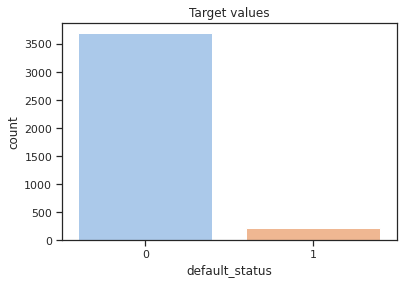

In [252]:
sns.countplot(x='default_status',data=df_full)
plt.title('Target values')
plt.show()

In [253]:
df_full.groupby(['default_status', 'organizationType']).mean()

id  ...  Управленческие расходы
default_status organizationType               ...                        
0              Large             2130.706487  ...            3.476119e+07
               Small             2230.459775  ...            7.417983e+06
1              Large             2151.500000  ...            5.135242e+06
               Small             2342.640777  ...            3.699282e+06

[4 rows x 34 columns]

The share of default states in the sample is very low and amounts to 223, i.e. 5.69% of the total number of observations. There were 2 peaks: the first in 2018 and the second in 2020, most likely due to a pandemic. At all times, construction firms have the highest default, but it should also be taken into account that this is the most widely represented area - about 40% of the total number of companies. Most often, wholesale companies that are dealing with food products, household goods, and non-specialized trade go bankrupt.

The final dataset consists primarily of a financial block. The remaining gaps were replaced with zeros, since the data is unknown and after highly correlated indicators were dropped, in final 38 features remained.

If there were more time, then it would be possible to analyze the dynamics of financial indicators from year to year and the time series, as well as study the companies principal activities.

# Part 2 ‐ Experiment and metrics design



## 2.1. Train datasets

The good news is a corporate default is a rare event, but also our classification problem turns out to be very imbalanced: around 5.7% of the firms were in a default state.

To overcome this problem, we will consider two cases:
- first, we use the entire dataset. For some algorithms, were applicable, with a hyperparameter "class weight" set up as "balanced";
- second, we will also create a balanced dataset by over-sampling the minority class namely using Synthetic Minority Over-sampling Technique (SMOTE) algorithm developed by Chawla et al. (2002).

We are not taking into account a way of creating balanced dataset in which we are selecting all the firms that defaulted and an equal number of random firms that did not default or downsampling since the size of the dataset would be very small and insufficient to fit the models.

## 2.2. Metric for models

The AUC-ROC curve will be used as the quality metric.

To analyze, in a robust way, the results obtained with this indicator, we specify the risks associated with it. 
For example, when a bank provides a loan to an enterprise, it faces two types of errors: 
- to refuse a loan to a company whose probability of default is much lower than the one obtained with the model (Type I error);
- to agree to provide a loan to a company whose probability of default is much higher than the value obtained with the selected model (Type II error). 

Thus, as soon as the AUC-ROC value increases and get closer to the 1, it means that we have less chance to make this kind of mistakes.

# Part 3 ‐ Predictive modeling

## 3.1. Data preparation

### 3.1.1. Creating dummy variables

In [254]:
df_full = df_full.drop(['id'], axis=1)

In [255]:
df_full.rename(columns={'Финансовые вложения (за исключением денежных эквивалентов)':'Финансовые вложения',
                         'Результат от переоценки внеоборотных активов, не включаемый в чистую прибыль (убыток)':'Результат от переоценки внеоборотных активов',
                         'Результат от прочих операций, не включаемый в чистую прибыль (убыток) периода':'Результат от прочих операций'},
                         inplace=True)

In [256]:
cat_cols=['organizationType', 'num_of_forms']

for col in cat_cols:
    cat_list='col'+'_'+col
    cat_list = pd.get_dummies(df_full[col], prefix=col)
    df_full_1 = df_full.join(cat_list)
    df_full = df_full_1

In [257]:
cat_cols=['organizationType', 'num_of_forms']

df_full_cols = df_full.columns.values.tolist()
to_keep = [i for i in df_full_cols if i not in cat_cols]
df_final = df_full[to_keep]
df_final.columns.values

array(['default_status', 'Баланс', 'Дебиторская задолженность',
       'Добавочный капитал (без переоценки)',
       'Доходные вложения в материальные ценности',
       'Доходы будущих периодов', 'Запасы', 'Кредиторская задолженность',
       'Материальные поисковые активы', 'НДС по приобретенным ценностям',
       'Нематериальные активы',
       'Нераспределенная прибыль (непокрытый убыток)',
       'Основные средства', 'Оценочные обязательства',
       'Переоценка внеоборотных активов', 'Прочие внеоборотные активы',
       'Прочие оборотные активы', 'Прочие обязательства',
       'Резервный капитал', 'Результаты исследований и разработок',
       'Собственные акции, выкупленные у акционеров', 'Уставный капитал',
       'Финансовые вложения', 'Выручка',
       'Изменение отложенных налоговых активов',
       'Изменение отложенных налоговых обязательств',
       'Коммерческие расходы', 'Проценты к получению', 'Прочее',
       'Результат от переоценки внеоборотных активов',
       'Резу

### 3.1.2. Over-sampling using SMOTE

In [258]:
X = df_final.loc[:, df_final.columns != 'default_status']
y = df_final.loc[:, df_final.columns == 'default_status']

In [259]:
os = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
columns = X_train.columns

In [260]:
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['default_status'])

In [261]:
print(f'Length of oversampled data is {len(os_data_X)}')

print('Number of non default in oversampled data ', len(os_data_y[os_data_y['default_status']==0]))
print('Number of default ', len(os_data_y[os_data_y['default_status']==1]))

print('Ratio of non default data in oversampled data is ',len(os_data_y[os_data_y['default_status']==0])/len(os_data_X))
print('Ratio of default data in oversampled data is ', len(os_data_y[os_data_y['default_status']==1])/len(os_data_X))

Length of oversampled data is 5198
Number of non default in oversampled data  2599
Number of default  2599
Ratio of non default data in oversampled data is  0.5
Ratio of default data in oversampled data is  0.5


In [262]:
print(X_train.shape, y_train.shape)
print(os_data_X.shape, os_data_y.shape)

(2742, 42) (2742, 1)
(5198, 42) (5198, 1)


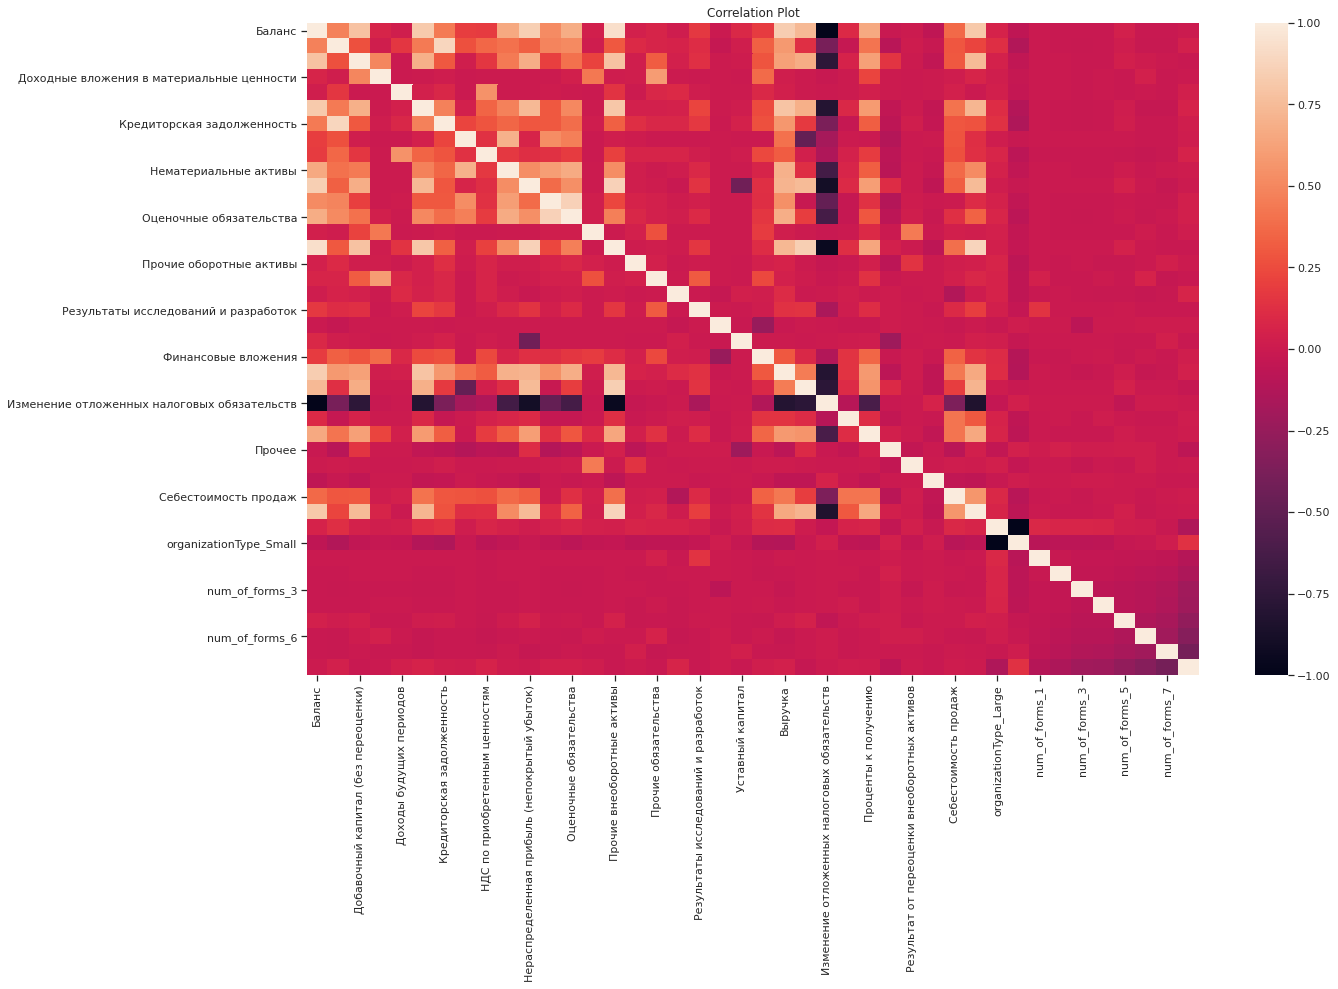

In [263]:
plt.title("Correlation Plot")
sns.heatmap(X_train.corr())
fig = plt.gcf()
fig.set_size_inches(20,12)
plt.show()

### 3.1.3. Feature scaling

In [264]:
numeric = [col for col in X_train.columns if X_train[col].dtype == 'int64']

In [265]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
os_data_X[numeric] = scaler.transform(os_data_X[numeric])

In [266]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(os_data_X.shape)

(2742, 42)
(588, 42)
(588, 42)
(5198, 42)


## 3.2. Modeling

### 3.2.1. Logistic regression

In [267]:
lr_start = time.time()

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)
y_pred_proba = lr.predict_proba(X_valid)[:, 1]

lr_duration = (time.time() - lr_start) % 60
lr_roc_auc = roc_auc_score(y_valid, y_pred_proba)

print('Logistic regression')
print(f'Time: {lr_duration:.3f} sec')
print(f'AUC-ROC: {lr_roc_auc:.3f}')

Logistic regression
Time: 0.040 sec
AUC-ROC: 0.849


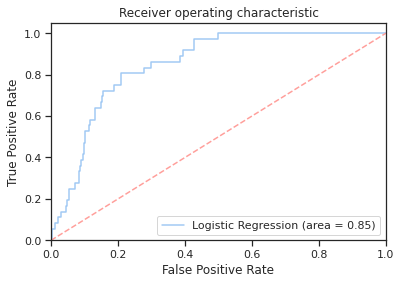

In [268]:
plt.figure()
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [269]:
lr_smote_start = time.time()

lr_smote = LogisticRegression()
lr_smote.fit(os_data_X, os_data_y)
y_smote_pred = lr_smote.predict(X_valid)
y_smote_pred_proba = lr_smote.predict_proba(X_valid)[:, 1]

lr_smote_duration = (time.time() - lr_smote_start) % 60
lr_smote_roc_auc = roc_auc_score(y_test, y_smote_pred_proba)

print('Logistic regression with SMOTE')
print(f'Time: {lr_smote_duration:.3f} sec')
print(f'AUC-ROC: {lr_smote_roc_auc:.3f}')

Logistic regression with SMOTE
Time: 0.115 sec
AUC-ROC: 0.501


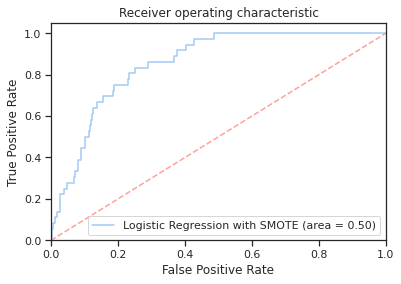

In [270]:
plt.figure()
fpr, tpr, thresholds = roc_curve(y_valid, y_smote_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression with SMOTE (area = %0.2f)' % lr_smote_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 3.2.2. Random Forest

In [271]:
rf_start = time.time()

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_valid)
rf_y_pred_proba = rf.predict_proba(X_valid)[:, 1]

rf_duration = (time.time() - rf_start) % 60
rf_roc_auc = roc_auc_score(y_valid, rf_y_pred_proba)

print('Random Forest Classifier')
print(f'Time: {rf_duration:.3f} sec')
print(f'AUC-ROC: {rf_roc_auc:.3f}')

Random Forest Classifier
Time: 0.496 sec
AUC-ROC: 0.919


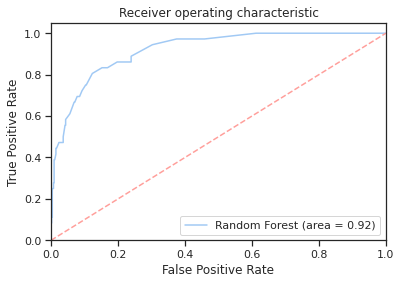

In [272]:
plt.figure()
fpr, tpr, thresholds = roc_curve(y_valid, rf_y_pred_proba)
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [273]:
model = RandomForestClassifier(random_state=42, class_weight='balanced')

parameters = {'n_estimators': [20, 40, 80, 200, 300], 
              'max_depth': [2, 4, 6, 8]}
              
gcv = GridSearchCV(model, parameters, cv=3)
gcv.fit(X_train, y_train)
print(f'Best hyperparameters: {gcv.best_params_}')

Best hyperparameters: {'max_depth': 8, 'n_estimators': 40}


In [274]:
rf_start = time.time()

rf = RandomForestClassifier(n_estimators=300, max_depth=8,
                            random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_valid)
rf_y_pred_proba = rf.predict_proba(X_valid)[:, 1]

rf_duration = (time.time() - rf_start) % 60
rf_roc_auc = roc_auc_score(y_valid, rf_y_pred_proba)

print('Random Forest Classifier')
print(f'Time: {rf_duration:.3f} sec')
print(f'Roc_auc: {rf_roc_auc:.3f}')

Random Forest Classifier
Time: 1.274 sec
Roc_auc: 0.910


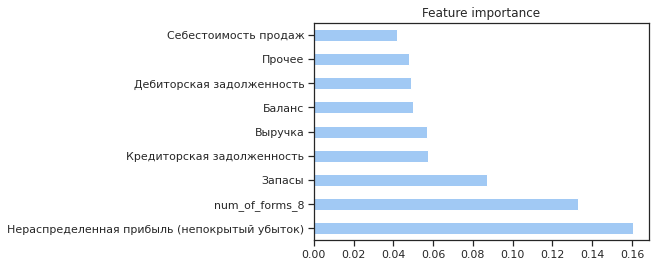

In [275]:
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)
plt.title('Feature importance')
z = feature_importance.nlargest(9).plot(kind='barh')

### 3.2.3. LightGBM

In [276]:
lgbm_start = time.time()

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_y_pred = lgbm.predict(X_valid)
lgbm_y_pred_proba = lgbm.predict_proba(X_valid)[:, 1]

lgbm_duration = (time.time() - lgbm_start) % 60
lgbm_roc_auc = roc_auc_score(y_valid, lgbm_y_pred_proba)

print('LightGBM Classifier')
print(f'Time: {lgbm_duration:.3f} sec')
print(f'AUC-ROC: {lgbm_roc_auc:.3f}')

LightGBM Classifier
Time: 0.506 sec
AUC-ROC: 0.877


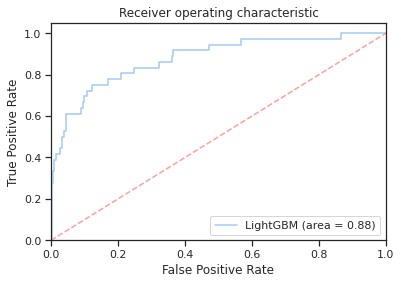

In [277]:
plt.figure()
fpr, tpr, thresholds = roc_curve(y_valid, lgbm_y_pred_proba)
plt.plot(fpr, tpr, label='LightGBM (area = %0.2f)' % lgbm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 3.2.4. XGBoost

In [278]:
xgb_start = time.time()

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_valid)
xgb_y_pred_proba = xgb.predict_proba(X_valid)[:, 1]

xgb_duration = (time.time() - xgb_start) % 60
xgb_roc_auc = roc_auc_score(y_valid, xgb_y_pred_proba)

print('XGBoost Classifier')
print(f'Time: {xgb_duration:.3f} sec')
print(f'AUC-ROC: {xgb_roc_auc:.3f}')

XGBoost Classifier
Time: 0.443 sec
AUC-ROC: 0.916


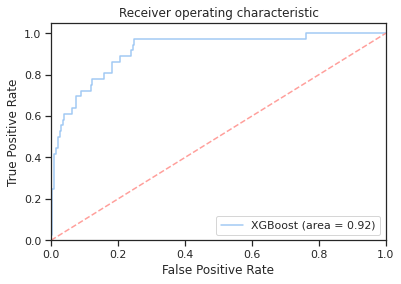

In [279]:
plt.figure()
fpr, tpr, thresholds = roc_curve(y_valid, xgb_y_pred_proba)
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## 3.3. Analysis of results

In [280]:
results = pd.DataFrame([['Logistic regression', lr_roc_auc, lr_duration], 
                        ['Logistic regression SMOTE', lr_smote_roc_auc, lr_smote_duration],
                        ['Random Forest', rf_roc_auc, rf_duration], 
                        ['LightGBM', lgbm_roc_auc, lgbm_duration],
                        ['XGBoost', xgb_roc_auc, xgb_duration]], 
                        columns=['Model', 'Roc-auc', 'Time'])

In [281]:
results_sorted = results.sort_values(['Roc-auc'], ascending=False)
results_sorted

,Model,Roc-auc,Time
4,XGBoost,0.916063,0.443292
2,Random Forest,0.910074,1.273890
3,LightGBM,0.876912,0.505707
0,Logistic regression,0.848833,0.039908
1,Logistic regression SMOTE,0.500836,0.115463


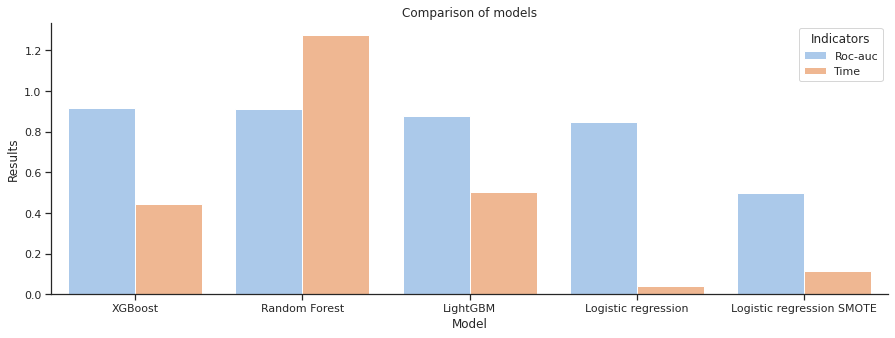

In [282]:
results_plot = pd.melt(results_sorted , id_vars='Model').rename(columns={'variable':'Indicators', 'value':'Results'})
fig, ax1 = plt.subplots(figsize=(15, 5))
sns.barplot(x='Model' , y='Results', hue='Indicators', data=results_plot, ax=ax1)
plt.title('Comparison of models')
sns.despine(fig)

In [283]:
# final check
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)
xgb_y_pred_proba = xgb.predict_proba(X_test)[:, 1]
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred_proba)

print('XGBoost Classifier')
print(f'AUC-ROC on test set: {xgb_roc_auc:.3f}')

XGBoost Classifier
AUC-ROC on test set: 0.893


# Conclusion

In this work we used a dataset that includes financial indicators for 3,918 firms for the years 2002-19 to predict the default of companies, using machine learning techniques.

In total, 4 models were fitted and trained namely: Logistic Regression, Random Forest, LightGBM, and XGBoost. They were analyzed according to 2 criteria: the AUC-ROC curve and execution time.

The fastest one (no wonder) is the Logistic regression model, while the most accurate turns out to be XGBoost. At the same time, the training time for the current volume of data is decent.

Based on this, we define the XGBoost as the best model with the winning time&quality ratio.